In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
data_path = '../bitcoin_scrapy/update/0711_10000/all_filter_update_0711_minimun.csv'
df = pd.read_csv('data/BTC-USD.csv')
df['timestamp'] = df['Date']
df['value'] = df['Close']

df['timestamp'] = pd.to_datetime(df['timestamp'])

scaler = MinMaxScaler()
df[['value']]= scaler.fit_transform(df[['value']])

# start_date = pd.to_datetime('2020-01-01')
# end_date = pd.to_datetime('2023-05-31')
# df = df[(df['timestamp']>= start_date) & (df['timestamp'] <= end_date)]
df = df.sort_values('timestamp', ascending=True)


# filtered_df = df.loc[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

# window_size = 7 # 窗口大小
# # sentiment['pos'] = sentiment['pos'].rolling(window_size).mean()

# df['value'] = df['value'].rolling(window_size).mean()
# df.set_index('timestamp', inplace=True)
# df.index = df.index.shift(window_size, freq='D')
# sentiment = df.reset_index()



print(df['timestamp'])
dates = list(df['timestamp'])
prices = list(df['value'])

# prices
# 绘制价格走势图
plt.figure(figsize=(30, 5))
plt.plot(dates, prices)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trend')

# plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-05-31'))


# lag hour测试

In [ ]:
import re
from sklearn.preprocessing import MinMaxScaler
import numpy as np
sentiment = pd.read_csv(data_path)
# sentiment = pd.read_csv("data/tweet_2020_01_full_result.csv")

sentiment = sentiment[sentiment['scores'].notnull()]
# filter
print(len(sentiment))
sentiment = sentiment[sentiment['label'] == 1]
print(len(sentiment))

print(len(sentiment))
thr = 100
sentiment = sentiment[(sentiment['user_follower_count'] > thr) | (sentiment['favorite_count'] > thr) | (sentiment['quote_count'] > thr) | (sentiment['reply_count'] > thr) | (sentiment['retweet_count'] > thr)]
print(len(sentiment))

sentiment['scores']  = sentiment['scores'].astype('str')
sentiment['pos'] = sentiment['scores'].str.split('\n').map(lambda row: float(row[0][4:]))
sentiment['neg'] = sentiment['scores'].str.split('\n').map(lambda row: float(row[1][4:]))
sentiment['neu'] = sentiment['scores'].str.split('\n').map(lambda row: float(row[2][4:]))
sentiment['day'] = pd.to_datetime(sentiment['day'])
sentiment = sentiment[(sentiment['day']>= pd.Timestamp('2022-01-01')) & (sentiment['day'] <= pd.Timestamp('2022-12-31'))]
def show_trend(sentiment, df, start, end, flag, lag):
    # print(sentiment.columns)
    sentiment = sentiment[sentiment['created_at'].notna()]
    sentiment['second'] = pd.to_datetime(sentiment['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

    # 小时平移
    sentiment.set_index('second', inplace=True)
    sentiment.index = sentiment.index.shift(lag, freq='H')
    sentiment = sentiment.reset_index()

    sentiment['day'] = sentiment['second'].dt.year.astype(str) + '-' + sentiment['second'].dt.month.astype(str) + '-' + sentiment['second'].dt.day.astype(str)
    sentiment['date'] = pd.to_datetime(sentiment['day'])

    # # 将日期列设置为索引
    # sentiment.set_index('date', inplace=True)
    # sentiment['hour']
    

    # sentiment['pos'] = sentiment['pos'] + sentiment['pos'] * sentiment['user_follower_count'] + sentiment['pos'] * sentiment['favorite_count']
    # sentiment['neg'] = sentiment['neg'] + sentiment['neg'] * sentiment['user_follower_count'] + sentiment['neg'] * sentiment['favorite_count']
    # sentiment['neu'] = sentiment['neu'] + sentiment['neu'] * sentiment['user_follower_count'] + sentiment['neu'] * sentiment['favorite_count']

    sentiment = sentiment.groupby(sentiment['date'])[['pos','neg','neu']].mean().reset_index()
    sentiment['metrics'] = sentiment['pos'] - sentiment['neg']
    print(sentiment.columns)
    

    # 归一化
    scaler = MinMaxScaler()
    sentiment[['metrics']]= scaler.fit_transform(sentiment[['metrics']])

    # 滑动窗口平滑
    window_size = 1 # 窗口大小
    sentiment['metrics'] = sentiment['metrics'].rolling(window_size).mean()

    sentiment['metrics_return'] = sentiment['metrics'].pct_change()
    df['value_return'] = df['value'].pct_change()
    sentiment = sentiment[sentiment['metrics_return']<9999999]
    df = df[df['value_return']<9999999]

    # 绘制价格走势图
    # trend = sentiment['metrics_return'].tolist()
    # sen_dates = sentiment['date'].tolist()
    # dates = list(df['timestamp'])
    # prices = list(df['value_return'])
    # print(len(trend),len(sen_dates))
    # print(len(prices))
    # if flag == 1:
    #     plt.figure(figsize=(60, 20))
    # plt.plot(dates, prices,label='Price_return')

    # plt.plot(sen_dates, trend,label='Sentiment_return')

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gcf().autofmt_xdate()
    # plt.xlabel('Date')
    # plt.ylabel('trend')
    # plt.title(start+'~'+end)
    # plt.ylim(-0.2,0.2)
    # plt.xlim(pd.Timestamp(start), pd.Timestamp(end))
    # plt.legend()
    # plt.show()

    # 计算相关系数
    sentiment = sentiment[sentiment['metrics_return'].notnull()]
    join = pd.merge(sentiment,df,left_on='date',right_on='timestamp')
    join = join[(join['date']>= pd.Timestamp(start)) & (join['date'] <= pd.Timestamp(end))]
    # print(join)
    
    t1 = join['metrics_return'].to_list()
    t2 = join['value_return'].to_list()
    good = 0
    for i in range(len(t1)):
        if t1[i] * t2[i] > 0:
            good = good + 1
    # print(good/len(t1))
    date = join['date'].to_list()
    corr = np.corrcoef(t1, t2)[0, 1]
    # print(len(date))
    
    return good/len(t1), corr
acc_list = []
corr_list = []
for lag in range(-24,25):
    acc, corr = show_trend(sentiment.copy(),df.copy(),'2020-01-01', '2023-05-31', 0, lag)
    acc_list.append(acc)
    corr_list.append(corr)
    print(lag ,"皮尔森相关系数为:", corr, "准确率为:",acc)

In [ ]:
# for i in range(-24,25):
#     print(i, acc_list[i+24], corr_list[i+24])
# 绘制价格走势图
plt.plot(range(-24,25), corr_list,label='corr')
plt.plot(range(-24,25), acc_list,label='acc')

# Add annotations for each point
# for lag, corr, acc in zip(range(-24,25), corr_list, acc_list):
#     if corr > 0.6:
#         plt.text(lag, corr, f'({lag}, {corr:.2f})', ha='center', va='bottom')
#         plt.text(lag, acc, f'({lag}, {acc:.2f})', ha='center', va='top')
print(corr_list)
print(acc_list)
for i in range(-24,25):
    print(i,corr_list[i+24],acc_list[i+24])
plt.xlabel('lag')
plt.ylabel('corr')
plt.title('lag (hour)')
plt.legend()
plt.show()

# hourly prediction

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('data/Price_OHLC_hourly.csv')

df['value'] = df['c']
df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df[(df['timestamp']>=pd.Timestamp('2020-01-01 00:00:00')) & (df['timestamp'] <=pd.Timestamp('2023-05-31 23:00:00'))]
df = df[df['value'].notna()]
scaler = MinMaxScaler()
df[['value']]= scaler.fit_transform(df[['value']])


In [ ]:
sentiment = pd.read_csv('../bitcoin_scrapy/update/0711_10000/all_filter_update_0711_minimun.csv',dtype={'id':str})
sentiment = sentiment[sentiment['scores'].notnull()]
# filter
print(len(sentiment))
sentiment = sentiment[sentiment['label'] == 1]
print(len(sentiment))
print(len(sentiment))
thr = 100
sentiment = sentiment[(sentiment['user_follower_count'] > thr) | (sentiment['favorite_count'] > thr) | (sentiment['quote_count'] > thr) | (sentiment['reply_count'] > thr) | (sentiment['retweet_count'] > thr)]
print(len(sentiment))

sentiment['scores']  = sentiment['scores'].astype('str')
sentiment['pos'] = sentiment['scores'].str.split('\n').map(lambda row: float(row[0][4:]))
sentiment['neg'] = sentiment['scores'].str.split('\n').map(lambda row: float(row[1][4:]))
sentiment['neu'] = sentiment['scores'].str.split('\n').map(lambda row: float(row[2][4:]))

sentiment['hour'] = pd.to_datetime(sentiment['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
sentiment['hour'] = sentiment['hour'].dt.floor('H')
# sentiment['hour']

sentiment = sentiment.groupby(sentiment['hour'])[['pos','neg','neu']].mean().reset_index()
sentiment['metrics'] = sentiment['pos'] - sentiment['neg']

# 归一化
scaler = MinMaxScaler()
sentiment[['metrics']]= scaler.fit_transform(sentiment[['metrics']])
# 滑动窗口平滑
# window_size = 1 # 窗口大小
# sentiment['metrics'] = sentiment['metrics'].rolling(window_size).mean()
# 计算return
sentiment['metrics_return'] = sentiment['metrics'].pct_change()
df['value_return'] = df['value'].pct_change()

join = pd.merge(sentiment, df, left_on='hour',right_on='timestamp')
join

In [ ]:
join.to_csv('hourly_join.csv',index=False)

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
join = pd.read_csv('hourly_join.csv')
# join['metrics'] = join['metrics'].shift(1)
# print(join)

def test(join, window_size, peroid, price_period,lag):

    join['metrics'] = join['metrics'].shift(lag)
    join = join[join['metrics'].notna()]

    window_size = window_size # 窗口大小
    join['metrics'] = join['metrics'].rolling(window_size).mean()

    scaler = MinMaxScaler()
    join[['metrics']]= scaler.fit_transform(join[['metrics']])

    join['metrics_return'] = join['metrics'].pct_change(periods=peroid)
    join['value_return'] = join['value'].pct_change(periods=price_period)
    # join = join[join['metrics_return'] >= 0.005]
    join = join[join['metrics_return'].notna()]
    join = join[join['value_return'].notna()]
    join = join[join['metrics_return']<99999]
    join = join[join['value_return']<99999]

    join['hour'] = pd.to_datetime(join['hour'])
    # print(join)
    join = join[join['hour'].dt.year==2020]
    # print(join['hour'].dt.hour)

    # print(join)
    t1 = join['metrics_return'].to_list()
    t2 = join['value_return'].to_list()
    good = 0
    thr = 0.001
    all = 0
    for i in range(len(t1)):
        if t1[i] * t2[i] > 0:
            good = good + 1
    corr = np.corrcoef(t1, t2)[0, 1]
    print(window_size,peroid,'acc',good/len(t1),'corr',corr)
    return good/len(t1),corr
# test(join,1,1,6)
acc_list = []
corr_list = []

for i in range(24):
    # for j in range(24):
    # acc,corr = test(join.copy(),i + 1,1,1,1)
    acc,corr = test(join.copy(),1,i+1,i+1,i+1)
    acc_list.append(acc)
    corr_list.append(corr)

C:\Users\67093\AppData\Local\Temp\ipykernel_10792\4204873757.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  join['metrics'] = join['metrics'].rolling(window_size).mean()
C:\Users\67093\AppData\Local\Temp\ipykernel_10792\4204873757.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  join[['metrics']]= scaler.fit_transform(join[['metrics']])
C:\Users\67093\AppData\Local\Temp\ipykernel_10792\4204873757.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

1 1 acc 0.5052710843373494 corr 0.004011162040305711
1 2 acc 0.5008787346221442 corr 0.0027351456086599476
1 3 acc 0.5010045203415369 corr -0.002482504698351456
1 4 acc 0.4905802562170309 corr -0.007323676764984457
1 5 acc 0.4993718592964824 corr -0.008174141302211188
1 6 acc 0.5005026388539834 corr -0.0015550671069740271
1 7 acc 0.49333836098541983 corr 0.004691924607065618
1 8 acc 0.49446819210460147 corr -9.528318370636398e-05
1 9 acc 0.49836519114688127 corr 0.006284947394327413
1 10 acc 0.4978616352201258 corr 0.013425927174874357
1 11 acc 0.49660291897332665 corr 0.006851981107685612
1 12 acc 0.5076768185250441 corr -0.001966540261961421
1 13 acc 0.5105740181268882 corr 0.00485871115022333
1 14 acc 0.5088139007806598 corr 0.0023090212943120353
1 15 acc 0.510831234256927 corr -0.0005936838849309873


C:\Users\67093\AppData\Local\Temp\ipykernel_10792\4204873757.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  join['metrics'] = join['metrics'].rolling(window_size).mean()
C:\Users\67093\AppData\Local\Temp\ipykernel_10792\4204873757.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  join[['metrics']]= scaler.fit_transform(join[['metrics']])
C:\Users\67093\AppData\Local\Temp\ipykernel_10792\4204873757.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

1 16 acc 0.5050390526581002 corr 0.000956466070609912
1 17 acc 0.5042842741935484 corr -0.00444656679927148
1 18 acc 0.5016385177716158 corr -0.008455291417702565
1 19 acc 0.4977307110438729 corr -0.012584431284184022
1 20 acc 0.4998738965952081 corr -0.013167482547506177
1 21 acc 0.5032795156407669 corr -0.014485060788476299
1 22 acc 0.5022710068130204 corr -0.014992232948455898
1 23 acc 0.49659262998485615 corr -0.011443647589617086


C:\Users\67093\AppData\Local\Temp\ipykernel_10792\4204873757.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  join['metrics'] = join['metrics'].rolling(window_size).mean()
C:\Users\67093\AppData\Local\Temp\ipykernel_10792\4204873757.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  join[['metrics']]= scaler.fit_transform(join[['metrics']])
C:\Users\67093\AppData\Local\Temp\ipykernel_10792\4204873757.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

1 24 acc 0.48788184801817724 corr -0.012435847177459056


[0.004011162040305711, 0.0027351456086599476, -0.002482504698351456, -0.007323676764984457, -0.008174141302211188, -0.0015550671069740271, 0.004691924607065618, -9.528318370636398e-05, 0.006284947394327413, 0.013425927174874357, 0.006851981107685612, -0.001966540261961421, 0.00485871115022333, 0.0023090212943120353, -0.0005936838849309873, 0.000956466070609912, -0.00444656679927148, -0.008455291417702565, -0.012584431284184022, -0.013167482547506177, -0.014485060788476299, -0.014992232948455898, -0.011443647589617086, -0.012435847177459056]
[0.5052710843373494, 0.5008787346221442, 0.5010045203415369, 0.4905802562170309, 0.4993718592964824, 0.5005026388539834, 0.49333836098541983, 0.49446819210460147, 0.49836519114688127, 0.4978616352201258, 0.49660291897332665, 0.5076768185250441, 0.5105740181268882, 0.5088139007806598, 0.510831234256927, 0.5050390526581002, 0.5042842741935484, 0.5016385177716158, 0.4977307110438729, 0.4998738965952081, 0.5032795156407669, 0.5022710068130204, 0.4965926

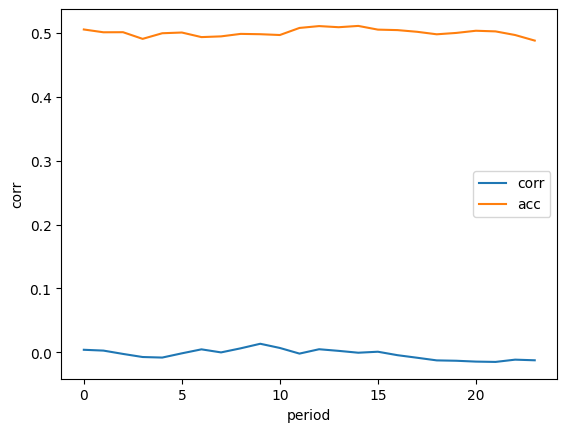

In [31]:

# 绘制价格走势图
plt.plot(range(24), corr_list,label='corr')
plt.plot(range(24), acc_list,label='acc')
print(corr_list)
print(acc_list)
# for i in range(-24,25):
#     print(i,corr_list[i+24],acc_list[i+24])
plt.xlabel('period')
plt.ylabel('corr')
# plt.title('lag (hour)')
plt.legend()
plt.show()